In [1]:
with open("./karpathy/names.txt", "r") as file:
    words = file.read().split("\n")
len(words)

32033

In [173]:
import random

class TrigramCounter:
    
    def __init__(self, key:str):
        self.key = key
        self.counts = {}
        
    def incr(self, key):
        if key not in self.counts:
            self.counts[key] = 1
        else:
            self.counts[key] += 1
    
    def selection(self):
        return random.choices(list(self.counts.keys()), weights=self.counts.values(), k=1)[0]


c = TrigramCounter("ab")
c.incr('b')
c.incr('b')
c.incr('b')
c.incr('b')
c.incr('b')

c.incr('a')
c.incr('a')
c.incr('a')

c.incr('c')

c.incr('d')

counter = BigramCounter("aa")

for i in range(10000):
    counter.incr(c.selection())

counter.counts

{'b': 5016, 'a': 3042, 'd': 989, 'c': 953}

In [180]:
class Trigram:
    
    def __init__(self):
        
        self.counters = {}
        
    def add_word(self, word:str):
        for i in range(2, len(word)):
            key = word[i-2:i]
            value = word[i]
            if key not in self.counters:
                self.counters[key] = TrigramCounter(key)
            self.counters[key].incr(value)
        end_key = word[len(word)-2:]
        if end_key not in self.counters:
            self.counters[end_key] = TrigramCounter(end_key)
        self.counters[end_key].incr("")
    
    def emit(self, prefix:str):
        key = prefix[-2:]
        if key in self.counters:
            return self.counters[key].selection()
        else:
            return ""


start_tokens = '00'
        
model = Trigram()
for word in words:
    model.add_word(start_tokens + word)
    

name = start_tokens
for i in range(5):
    next_char = model.emit(name)
    if next_char == "":
        break
    name += next_char
    
print(name[2:])

osbel


In [2]:
import torch

N = torch.zeros((28,28), dtype=torch.int32)

start_token = '<s>'
end_token = '<e>'

token_lookup = {k:i for i, k in enumerate("abcdefghijklmnopqrstuvwxyz")}
token_lookup[start_token] = 26
token_lookup[end_token] = 27

token_lookup

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '<s>': 26,
 '<e>': 27}

In [128]:
for sword in words:
    word = [start_token] + list(sword) + [end_token]
    for i in range(2, len(word)):
        c1, c2 = (token_lookup[c] for c in word[i-1:i+1])
        N[c1,c2] += 1

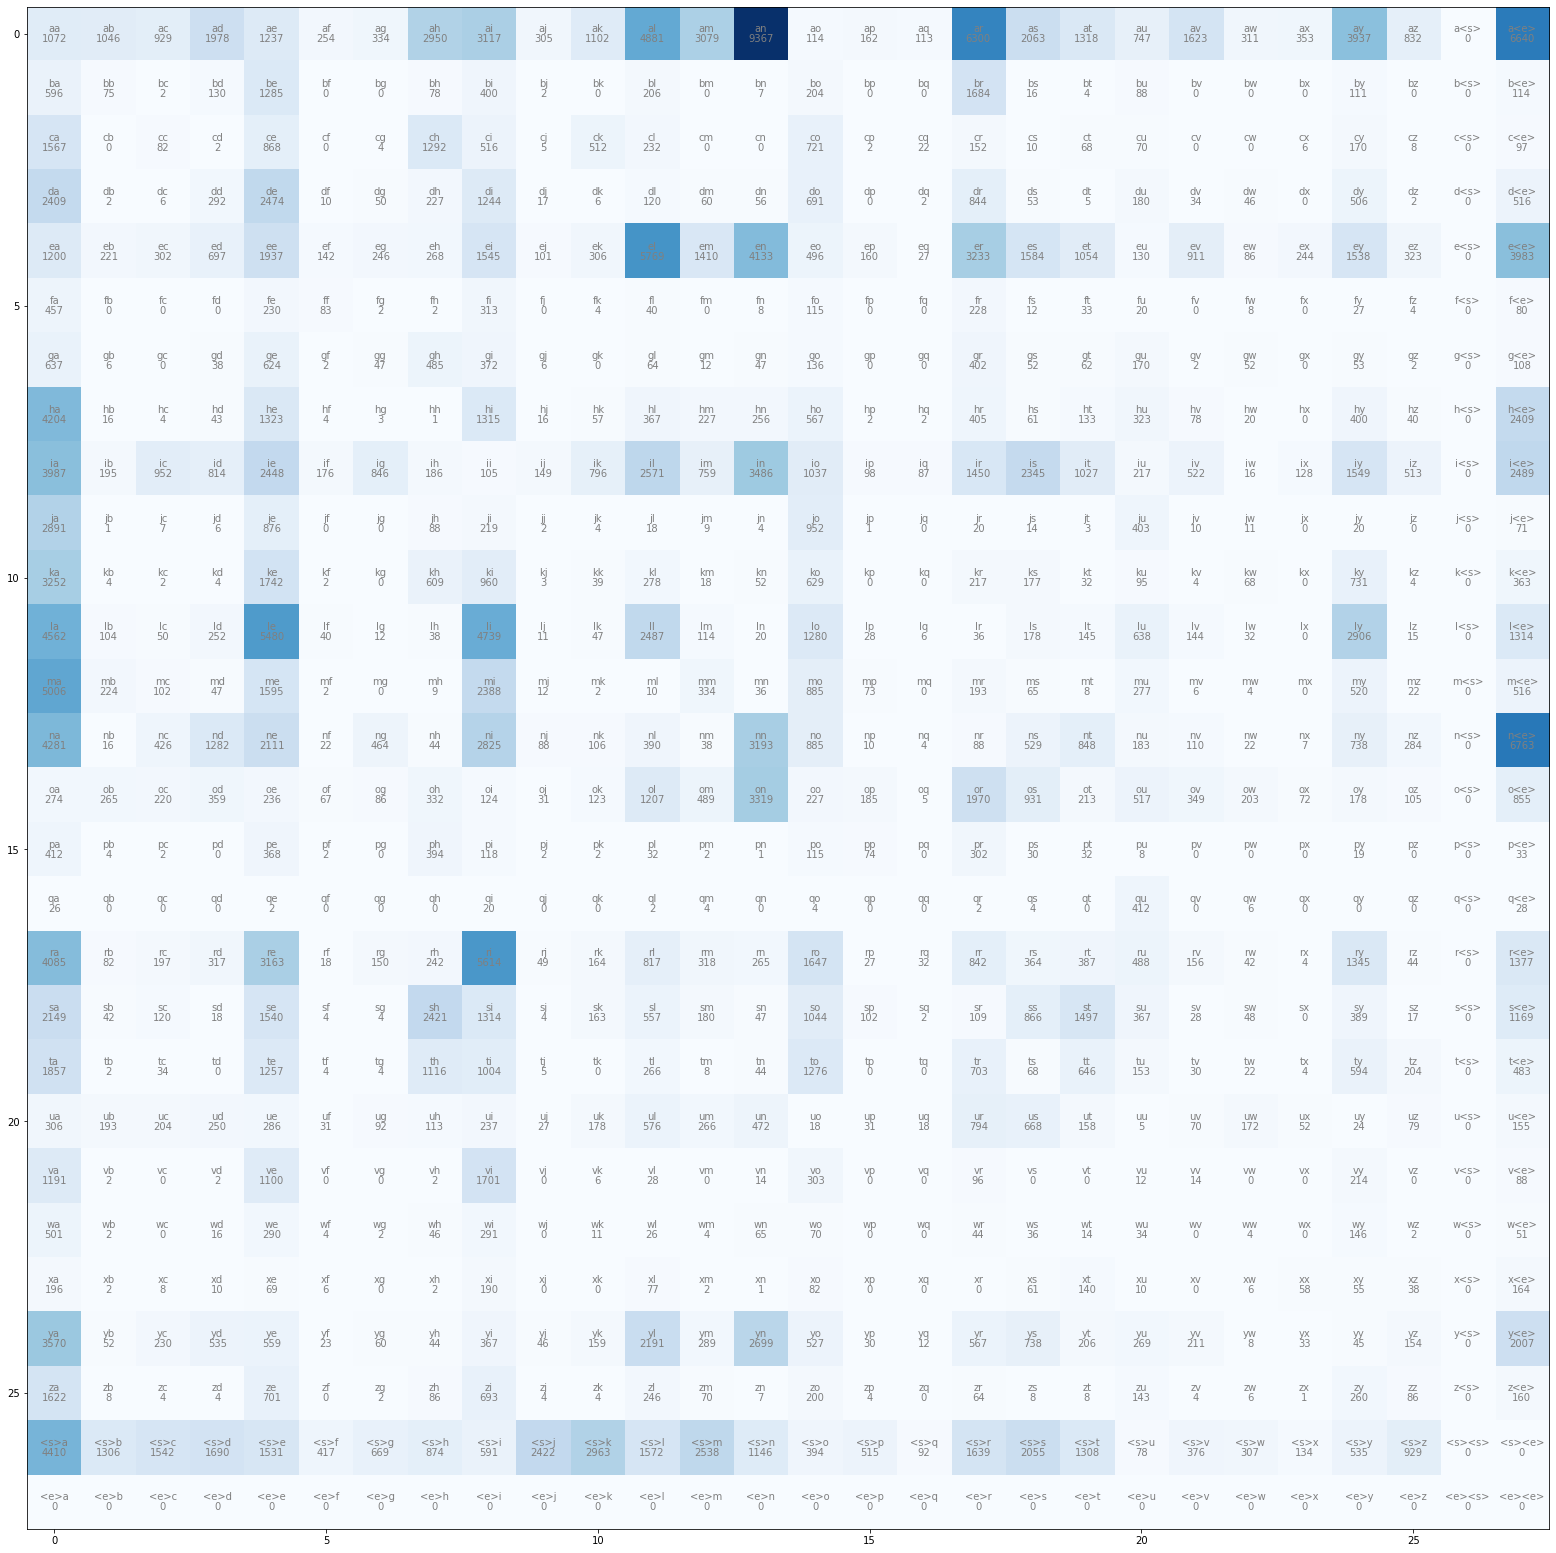

In [129]:
import matplotlib.pyplot as plt

char_lookup = {token_lookup[k]:k for k in token_lookup}

plt.figure(figsize=(28,28))
plt.imshow(N, cmap='Blues')

for i in range(N.shape[0]):
    for j in range(N.shape[1]):
        ch_str = char_lookup[i] + char_lookup[j]
        plt.text(j, i, ch_str, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")
        

In [151]:
g = torch.Generator().manual_seed(2147483647)
p = N[26].float()
p = p / p.sum()
p

tensor([0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273, 0.0184,
        0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029, 0.0512,
        0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290, 0.0000,
        0.0000])

In [208]:
P = N.float()
P = P / P.sum(dim=1, keepdim=True)
P.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           nan])

In [205]:
name = ""

ix = 26
while True:
    ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=g).item()
    name += char_lookup[ix]
    if ix == 27:
        break
name

'alo<e>'

In [20]:

class NGramModel:
    
    def __init__(self, n:int, w:int, token_table:dict, start_token:int, end_token:int):
        
        self.n = n
        self.w = w
        self.token_table = token_table
        self.start_token = start_token
        self.end_token = end_token
        self.N = torch.zeros([w] * n, dtype=torch.int16)
        
    def add_word(self, word:str):
        tokens = ([self.start_token] * (self.n - 1)) + [self.token_table[c] for c in list(word)] + ([self.end_token] * (self.n - 1))
        for i in range(self.n, len(tokens)+1):
            self.N[tuple(tokens[i-self.n:i])] += 1
    
    def add_words(self, words:list):
        for word in words:
            self.add_word(word)
        self.P = self.N / self.N.sum(dim=-1, keepdim=True)
            
    def sample(self, tokens:list=None, q:int=64):
        on = self.n - 1
        if tokens is None:
            tokens = [self.start_token] * on
        while q > 0:
            ix = torch.multinomial(self.P[tuple(tokens[-on:])], num_samples=1, replacement=True).item()
            tokens.append(ix)
            if ix == self.end_token:
                break
            q -= 1
        return tokens[on-1:]
        

In [354]:
model = NGramModel(4, 28, token_lookup, 26, 27)
model.add_words(words)
model.sample()

[26, 13, 8, 21, 0, 13, 27]

In [357]:
for i in range(20):
    name = "".join(char_lookup[x] for x in model.sample()[1:-1])
    name = name[0].upper() + name[1:]
    print(name)

Javy
Jerrick
Ema
Sabinnorel
Dax
Kendonte
Haynoleddison
Hayde
Boyalissa
Yimier
Covin
Merina
Essen
Jeze
Dwig
Siva
Abdulsa
Hena
Reeah
Kira


In [22]:
with open('./karpathy/book.txt', 'r') as f:
    book_text = f.read()
    
start_token = '<bos>'
end_token = '<eos>'

book_characters = set(book_text)

book_token_lookup = {k:i+1 for i, k in enumerate(book_characters)}
book_token_lookup[start_token] = 0
book_token_lookup[end_token] = len(book_characters) + 1
book_character_lookup = {i:k for k, i in book_token_lookup.items()}

book_model = NGramModel(5, len(book_characters) + 2, book_token_lookup, 0, len(book_characters) + 1)
book_model.add_words([book_text])

In [23]:
print("".join(book_character_lookup[x] for x in book_model.sample(q=256)))

<bos>The sought law in writted States are that required Ellis. How couldn't me, memora, but hesitation, who warn move to provide a commercially drifted I could print entities of thing?" Dixon had living of the jolts.

"Don't know
it's going as
internations may 


In [45]:
import re

cleaned_book_text = book_text.lower().replace("\n"," ")
cleaned_book_text = re.sub(r'[^a-zA-Z0-9\s]', ' ', cleaned_book_text)
book_words = [token for token in cleaned_book_text.split(" ") if token != ""]
book_word_tokens = set(book_word_tokens)

book_word_token_lookup = {k:i+1 for i, k in enumerate(book_word_tokens)}
book_word_token_lookup[start_token] = 0
book_word_token_lookup[end_token] = len(book_word_tokens) + 1
book_word_lookup = {i:k for k, i in book_word_token_lookup.items()}

book_word_model = NGramModel(3, len(book_word_tokens) + 2, book_word_token_lookup, 0, len(book_word_tokens) + 1)
book_word_model.add_words([book_words])

In [54]:
prompt = "the man is a"
tokens = [book_word_token_lookup[x] for x in prompt.split(" ")]
print(" ".join(book_word_lookup[x] for x in book_word_model.sample(tokens=tokens)))

man is a non profit 501 c 3 educational corporation organized under the terms of the country where you are located also govern what you can do with most project gutenberg appears or with which he pursued any research you know of no prohibition against accepting unsolicited donations from donors in such states who approach us with offers to donate please visit www gutenberg org donate while
